In [1]:
import sys
import os
sys.path.insert(1, os.path.realpath(os.path.pardir))
from functions import *
# in order to get reproducable results
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1)
random.seed(1)

import cmapy
from pytorchtools import EarlyStopping
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Only GPU 3 is visible to this code
time1 = time.time()

In [2]:
parentfolder_path = os.path.abspath(os.path.join(sys.path[0], os.pardir))

## Finetune with xl2800

In [3]:
sectionNo = 2800
seis_path = "./gsbData/gsb_crl_{}.npy".format(sectionNo)
# fault_path = "./gsbData/gsb_crl_{}_mask.npy".format(sectionNo)
fault_path = "xl2800realgt.npy"

In [4]:
seis = np.load(seis_path)

In [5]:
IL, Z, XL = seis.shape
print(IL, Z, XL)

1 76 484


In [6]:
fault = np.load(fault_path)
print(fault.shape)

(1, 76, 484)


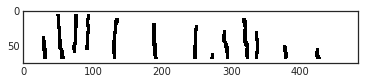

In [7]:
plt.imshow(np.squeeze(fault))

Make input is IL, Z, XL order.

In [8]:
best_iou_threshold=0.5
epoches = 200
patience = 20
im_height = Z
im_width = XL
splitsize = 96
stepsize = 1
overlapsize = splitsize-stepsize
pixelThre = 10 #int(0.03*splitsize*splitsize)
print(pixelThre)

10


In [9]:
horizontal_splits_number = int(np.ceil((im_width-overlapsize)/stepsize))
width_after_pad = stepsize*horizontal_splits_number+overlapsize
if width_after_pad < splitsize:
    horizontal_splits_number = 1
    width_after_pad = splitsize

left_pad = int((width_after_pad-im_width)/2)
right_pad = width_after_pad-im_width-left_pad
print("horizontal_splits_number", horizontal_splits_number)
print("width_after_pad", width_after_pad)
print("left_pad,right_pad",left_pad,right_pad)


vertical_splits_number = int(np.ceil((im_height-overlapsize)/stepsize))
height_after_pad = stepsize*vertical_splits_number+overlapsize
if height_after_pad <= splitsize:
    vertical_splits_number = 1
    height_after_pad = splitsize
top_pad = int((height_after_pad-im_height)/2)
bottom_pad = height_after_pad-im_height-top_pad
print("vertical_splits_number",vertical_splits_number)
print("height_after_pad",height_after_pad)
print("top_pad,bottom_pad", top_pad,bottom_pad)


horizontal_splits_number 389
width_after_pad 484
left_pad,right_pad 0 0
vertical_splits_number 1
height_after_pad 96
top_pad,bottom_pad 10 10


In [10]:
t_start = time.time()
X = []
Y = []
for i in range(len(seis)):
    mask = fault[i]
    splits = split_Image(mask,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
#     print(splits.shape)
    t = (splits.sum((1,2)) < pixelThre)
    no_label_element_index = list(compress(range(len(t)), t))
    # get all the indexes of the no label pieces by adding elements in axis 2 and 3.
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
#     print("splits.shape", splits.shape)
    Y.extend(splits)
    
    img = seis[i]
    splits = split_Image(img,True,top_pad,bottom_pad,left_pad,right_pad,splitsize,stepsize,vertical_splits_number,horizontal_splits_number)
    splits = np.delete(splits, no_label_element_index,0) # delete element i along axis 0
    X.extend(splits)

print(len(Y))
print(len(X))
print(X[0].shape)
print("read images in {} sec".format(time.time()-t_start))

t_start = time.time()
X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
print(X.shape)
print(Y.shape)
print("read images in {} sec".format(time.time()-t_start))

389
389
(96, 96)
read images in 0.031225204467773438 sec
(389, 96, 96)
(389, 96, 96)
read images in 0.024305343627929688 sec


In [11]:
if len(Y.shape) == 3:
    Y = np.expand_dims(Y, axis=-1)
if len(X.shape) == 3:
    X = np.expand_dims(X, axis=-1)
print(X.shape)
print(Y.shape)

(389, 96, 96, 1)
(389, 96, 96, 1)


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=1) #,shuffle=False
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)


(350, 96, 96, 1) (39, 96, 96, 1)
(350, 96, 96, 1) (39, 96, 96, 1)


In [13]:
aug_times = 9

t_start = time.time()
origin_train_size = len(X_train)
print(origin_train_size)
X_train_aug = np.zeros((origin_train_size*aug_times,splitsize,splitsize,1))
Y_train_aug = np.zeros((origin_train_size*aug_times,splitsize,splitsize,1))
for i in range(len(X_train)):
    for j in range(aug_times):
        aug = strong_aug(p=1)
        augmented = aug(image=X_train[i], mask=Y_train[i])
        X_train_aug[origin_train_size*j + i] = augmented['image']
        Y_train_aug[origin_train_size*j + i] = augmented['mask']
print("read images in {} sec".format(time.time()-t_start))

X_train_aug = X_train_aug.astype(np.float32)
Y_train_aug = Y_train_aug.astype(np.float32)
if len(X_train)==origin_train_size:
    X_train = np.append(X_train,X_train_aug, axis=0)
if len(Y_train)==origin_train_size:
    Y_train = np.append(Y_train, Y_train_aug, axis=0)
print("X_train after aug",X_train.shape) 
print("Y_train after aug",Y_train.shape)
print("read images in {} sec".format(time.time()-t_start))
X_train = X_train.astype(np.float32)
Y_train = Y_train.astype(np.float32)
#-----------------------
X_train = np.moveaxis(X_train,-1,1)
Y_train = np.moveaxis(Y_train,-1,1)
X_val = np.moveaxis(X_val,-1,1)
Y_val = np.moveaxis(Y_val,-1,1)
print("X_train",X_train.shape)
print("X_val",X_val.shape)
print("Y_train",Y_train.shape)
print("Y_val",Y_val.shape)

350
read images in 11.505072593688965 sec
X_train after aug (3500, 96, 96, 1)
Y_train after aug (3500, 96, 96, 1)
read images in 11.942770957946777 sec
X_train (3500, 1, 96, 96)
X_val (39, 1, 96, 96)
Y_train (3500, 1, 96, 96)
Y_val (39, 1, 96, 96)


# load pretrain model

In [14]:
modelNo = "rcf" # select one of ["unet", "deeplab", "hed", "rcf"]
checkpoint_path = "{}/checkpoints/noaugmodelsseed".format(parentfolder_path)
device = torch.device("cuda")
finetune_path = "{}/checkpoints/finetune".format(parentfolder_path)
if not os.path.exists(finetune_path):
    os.makedirs(finetune_path)
if modelNo == "unet":
    from model_zoo.UNET import Unet
    model = Unet()
    print("use model Unet")
    modelname = "unet_ft_96_1_shuffle_thick_9aug"
    best_model_fpath = '{}/{}.model'.format(checkpoint_path,"unet_96_48_900200_seed") 
    save_path = '{}/{}.model'.format(finetune_path,modelname)
elif modelNo == "deeplab":
    from model_zoo.DEEPLAB.deeplab import DeepLab
    model = DeepLab(backbone='mobilenet', num_classes=1, output_stride=16)
    print("use model DeepLab")
    modelname = "deeplab_ft_96_1_shuffle_thick_9aug"
    best_model_fpath = '{}/{}.model'.format(checkpoint_path,"mobilenet_96_48_900200_seed") 
    save_path = '{}/{}.model'.format(finetune_path,modelname)
elif modelNo == "hed":
    from model_zoo.HED import HED
    model = HED()
    print("use model HED") 
    modelname = "hed_ft_96_1_shuffle_thick_9aug"
    best_model_fpath = '{}/{}.model'.format(checkpoint_path,"hed_96_48_900200_seed3") 
    save_path = '{}/{}.model'.format(finetune_path,modelname)
elif modelNo == "rcf":
    from model_zoo.RCF import RCF
    model = RCF()
    print("use model RCF")
    modelname = "rcf_ft_96_1_shuffle_thick_9aug"
    best_model_fpath = '{}/{}.model'.format(checkpoint_path,"rcf_96_48_900200_seed") 
    save_path = '{}/{}.model'.format(finetune_path,modelname)
else:
    print("please enter a valid model")
# print(best_model_fpath)
# print(save_path)
model.load_state_dict(torch.load(best_model_fpath, map_location="cuda:0"))  # Choose whatever GPU device number you want
model.to(device)
summary(model, (1, splitsize, splitsize))

use model RCF
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 96, 96]             320
              ReLU-2           [-1, 32, 96, 96]               0
         Dropout2d-3           [-1, 32, 96, 96]               0
            Conv2d-4           [-1, 32, 96, 96]           9,248
              ReLU-5           [-1, 32, 96, 96]               0
         Dropout2d-6           [-1, 32, 96, 96]               0
         MaxPool2d-7           [-1, 32, 48, 48]               0
            Conv2d-8           [-1, 64, 48, 48]          18,496
              ReLU-9           [-1, 64, 48, 48]               0
        Dropout2d-10           [-1, 64, 48, 48]               0
           Conv2d-11           [-1, 64, 48, 48]          36,928
             ReLU-12           [-1, 64, 48, 48]               0
        Dropout2d-13           [-1, 64, 48, 48]               0
        MaxPool2d-14     

In [15]:
import torch.utils.data
# idea from: https://www.kaggle.com/erikistre/pytorch-basic-u-net
class faultsDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return (image, mask)


# In[32]:


faults_dataset_train = faultsDataset(X_train, train=True, preprocessed_masks=Y_train)
faults_dataset_val = faultsDataset(X_val, train=False, preprocessed_masks=Y_val)


batch_size = 64 

train_loader = torch.utils.data.DataLoader(dataset=faults_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=faults_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-9, momentum=0.9, weight_decay=0.0002)
print("optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.0002)")
if modelNo == "unet" or modelNo == "deeplab":
    print("optimizer = torch.optim.Adam(model.parameters(), lr=0.01)")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=10, eps=1e-15,verbose=True)


# In[ ]:


bceloss = nn.BCELoss()
mean_train_losses = []
mean_val_losses = []
mean_train_accuracies = []
mean_val_accuracies = []
t_start = time.time()
early_stopping = EarlyStopping(patience=patience, verbose=True, delta = 0)
for epoch in range(epoches):                  
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    labelled_val_accuracies = []

    model.train()
    for images, masks in train_loader: 
        torch.cuda.empty_cache()
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        
        loss = torch.zeros(1).cuda()
        y_preds = outputs
        if modelNo == "unet" or modelNo == "deeplab":
            loss = bceloss(outputs, masks) 
        elif modelNo == "hed":
            for o in range(5):
                loss = loss + cross_entropy_loss_HED(outputs[o], masks)
            loss = loss + bceloss(outputs[-1],masks)
            y_preds = outputs[-2]
        elif modelNo == "rcf":
            for o in outputs:
                loss = loss + cross_entropy_loss_RCF(o, masks)
            y_preds = outputs[-1]
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_losses.append(loss.data)
        predicted_mask = y_preds > best_iou_threshold
        train_acc = iou_pytorch(predicted_mask.squeeze(1).byte(), masks.squeeze(1).byte())
        train_accuracies.append(train_acc.mean())        

    model.eval()
    for images, masks in val_loader:
        torch.cuda.empty_cache()
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        
        loss = torch.zeros(1).cuda()
        y_preds = outputs
        if modelNo == "unet" or modelNo == "deeplab":
            loss = bceloss(outputs, masks) 
        elif modelNo == "hed":
            for o in range(5):
                loss = loss + cross_entropy_loss_HED(outputs[o], masks)
            loss = loss + bceloss(outputs[-1],masks)
            y_preds = outputs[-2]
        elif modelNo == "rcf":
            for o in outputs:
                loss = loss + cross_entropy_loss_RCF(o, masks)
            y_preds = outputs[-1]
        val_losses.append(loss.data)
        predicted_mask = y_preds > best_iou_threshold
        val_acc = iou_pytorch(predicted_mask.byte(), masks.squeeze(1).byte())
        val_accuracies.append(val_acc.mean())

        
    mean_train_losses.append(torch.mean(torch.stack(train_losses)))
    mean_val_losses.append(torch.mean(torch.stack(val_losses)))
    mean_train_accuracies.append(torch.mean(torch.stack(train_accuracies)))
    mean_val_accuracies.append(torch.mean(torch.stack(val_accuracies)))
    
    scheduler.step(torch.mean(torch.stack(val_losses)))    
    early_stopping(torch.mean(torch.stack(val_losses)), model, save_path)


    if early_stopping.early_stop:
        print("Early stopping")
        break
        

    torch.cuda.empty_cache()
    
    for param_group in optimizer.param_groups:
        learningRate = param_group['lr']
    
    
    # Print Epoch results
    t_end = time.time()

    print('Epoch: {}. Train Loss: {}. Val Loss: {}. Train IoU: {}. Val IoU: {}. Time: {}. LR: {}'
          .format(epoch+1, torch.mean(torch.stack(train_losses)), torch.mean(torch.stack(val_losses)), torch.mean(torch.stack(train_accuracies)), torch.mean(torch.stack(val_accuracies)), t_end-t_start, learningRate))
    
    t_start = time.time()



# In[ ]:
mean_train_losses = np.asarray(torch.stack(mean_train_losses).cpu())
mean_val_losses = np.asarray(torch.stack(mean_val_losses).cpu())
mean_train_accuracies = np.asarray(torch.stack(mean_train_accuracies).cpu())
mean_val_accuracies = np.asarray(torch.stack(mean_val_accuracies).cpu())

fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
train_loss_series = pd.Series(mean_train_losses)
val_loss_series = pd.Series(mean_val_losses)
train_loss_series.plot(label="train_loss")
val_loss_series.plot(label="validation_loss")
plt.legend()
plt.subplot(1, 2, 2)
train_acc_series = pd.Series(mean_train_accuracies)
val_acc_series = pd.Series(mean_val_accuracies)
train_acc_series.plot(label="train_acc")
val_acc_series.plot(label="validation_acc")
plt.legend()
plt.savefig('{}_loss_acc.png'.format(best_model_fpath))

totaltime = time.time()-time1
print("total cost {} seconds".format(totaltime))
print("total cost {} hours".format(totaltime/3600))

optimizer = torch.optim.SGD(model.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.0002)
Validation loss decreased (inf --> 2743584.750000).  Saving model ...
Epoch: 1. Train Loss: 5170969.5. Val Loss: 2743584.75. Train IoU: 0.119720958173275. Val IoU: 0.13633288443088531. Time: 17.84481167793274. LR: 1e-09
Validation loss decreased (2743584.750000 --> 2263545.250000).  Saving model ...
Epoch: 2. Train Loss: 4695656.5. Val Loss: 2263545.25. Train IoU: 0.14254087209701538. Val IoU: 0.20634368062019348. Time: 16.68990397453308. LR: 1e-09


KeyboardInterrupt: 